### Names of Students and ID:
### Group number:

# Clustering of image data with Mixture Models


We saw in the last project that mixture models / k-means are a powerful way to detect groups in multidimensional real data. However, mixture models can be easily generalized to other types of data.
The goal of the project is to implement a mixture model that can cluster image data using a mixture of bernoulli distributions.
This jupyter notebook will serve as a guide for the different steps of the implementation of the model and of its estimation. In the last part we will try to apply our model to recover missing part of an image! This is also called imputation.

You will find expected outputs throughout the notebook that should match your output for the same example input, given the correct implementation of the function bodys.

`Note:` Throughout the notebook you will find docstrings describing the in and output of the different functions, these are meant as hints to guide during the implementation. Whether you meet the exact type or not is up to you and will not be graded as long as your implementation returns the expected result. If your implementation is slow it might be sufficient to use half of the dataset for good results.

### For grading, you are just expected to fill in this notebook. Feel free to add text answers within the notebook whenever appropriate.

#### Have fun!

In [1]:
# Here are some helpful packages to solve this exercise
# You might need to restart the notebook kernel for these to be available for import after the installation
# The tensorflow package is only needed to load the MNIST datasets. You can avoid to installing it if you
# plan to download the table on your own.
"""%pip install tensorflow

%pip install matplotlib
%pip install numpy
%pip install scipy
%pip install plotly"""

'%pip install tensorflow\n\n%pip install matplotlib\n%pip install numpy\n%pip install scipy\n%pip install plotly'

# Know your data
Have a look at the `MNIST` data set below; Get familiar with how the data is structured, this will be important for later excercises as well!

We will use prepared versions of the datasets that are already available in [Keras](https://keras.io/getting_started/). You will need to install `keras` with `Tensorflow`. Alternatively there are also tabular versions to download on Kaggle of the [digit](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv) and the [fashion](https://www.kaggle.com/datasets/zalando-research/fashionmnist) datasets.

In [2]:
import keras
from keras.datasets import mnist
import numpy as np

(X_train, Y_train), (test_X, test_y) = mnist.load_data()
X_train = np.concatenate([X_train, test_X], axis=0)
Y_train = np.concatenate([Y_train, test_y], axis=0)
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))

example_1_X = X_train[8]
example_3_X = X_train[7]
example_7_X = X_train[40000]
example_7_y = Y_train[40000]
example_8_X = X_train[17]
print(f"This is a 7: \n{example_7_y}")
print(f"And it has shape: \n{example_7_X.shape}")
print(f"This is a 7's image data: \n{example_7_X}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
X_train: (70000, 28, 28)
Y_train: (70000,)
This is a 7: 
7
And it has shape: 
(28, 28)
This is a 7's image data: 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   

### 1) Get familiar with the dataset by plotting some of the $x_i$ in $X_{\text{train}}$.

From the last section you might have seen that the value matrices $x \in \mathbb{N}^{d\times d} $ are actually 2D numpy arrays of shape (d, d). These resemble the pixels in the image, where each value indicates the respective pixels intensity.

Have a look at how this translates into the actual image by plotting some examples below, this will come in handy later on!


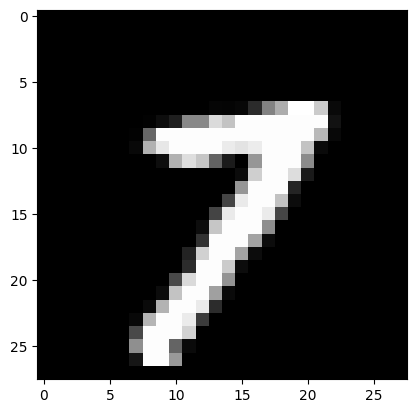

In [3]:
import matplotlib.pyplot as plt

# Plot some examples from X_train using matplotlib
plt.imshow(example_7_X, cmap = 'grey')

## 2) Preprocessing

You can see in the plot that the value matrices of the different $x$ contain values $\in \{0, 1, ..., 255\}$, representing pixel intensity on the grey scale. However, we want to reduce dimensionality for this project and transform all values to be in ${0,1}$ while keeping a meaningful representation of the original image. This will help us later when we want to think more in terms of probabilities, e.g., the probability for a pixel being on (white) given its image class. We can then model each pixel as an independant Bernoulli for our approximation. In addition, we will later work on (flattened matrices) vectors $\vec{v} \in \mathbb{N}^{d*d}$ instead of matrices $x \in \mathbb{N}^{d\times d}$.

2.a) Implement the fuction body of `binarize_image()` that flattens a given input matrix of dimension $d \times d$ and returns a binarized vector of dimension $d^2$, given a binarization `threshold`.

In [4]:
def binarize_image(xi_mat: np.ndarray, threshold: int = 127):
  """
  Convert 2D value matrix of shape (d, d) of greyscale image to 1D binary vector of shape (d * d).

  Parameters
  ----------
  xi_mat : np.ndarray
      A 2D NumPy array of shape (d, d) representing a grayscale image,
      where each element is a pixel intensity value between 0 and 255.

  threshold: int
      Decision threshold value above which all pixel values are set to 1,
      below (or equal to) which they are set to 0. Default is 127.

  Returns
  -------
  xi_bin_vec : np.array
      A 1D NumPy array of shape (d * d) representing the binary vector
      of the input image, where each element is either 0 or 1 (binary vector).
  """
  return (xi_mat.flatten() >= threshold).astype(int)


test_mat = np.array([
    [0, 127, 255],
    [255, 128, 0],
    [0, 126, 255]
])

test_mat = np.array([
       [ 80,  80,   0,   0,  80,   0,   0,  80,  80,  80],
       [ 80,   0, 255, 255,   0, 255, 255,   0,  80,  80],
       [ 80,   0, 255, 255, 255,   0, 255,   0,  80,  80],
       [ 80,  80,   0,   0,   0,   0,   0,   0,  80,  80],
       [ 80,   0,   0, 192,   0, 192, 192, 192,   0,  80],
       [  0, 192,   0, 192,   0, 192, 192, 192, 192,   0],
       [  0, 192,   0, 192,   0, 192, 192,  50, 192,   0],
       [  0, 192,   0, 192,   0, 192, 192, 192, 192,   0],
       [ 80,   0,   0, 192,   0, 192, 192, 192,   0,  80],
       [ 80,  80,   0,   0,   0,   0,   0,   0,  80,  80]
])

test_bin_vec = np.array([0, 0, 1, 1, 1, 0, 0, 0, 1])

test_bin_vec = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
                         1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
                         0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
                         1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1,
                         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Check if your function returns the expected result by comparing the matrices below
print(f"Expected binarized vector:\n{test_bin_vec}")
print(f"Binarized vector with your implementation:\n{binarize_image(test_mat)}")

assert np.array_equal(binarize_image(test_mat), test_bin_vec), "Binarized vector returned by your implementation is not equal to the expected vector."

Expected binarized vector:
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
Binarized vector with your implementation:
[0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]


Printed matrices are nice, but you can never _bee_ too sure with these things.

#### 2.b) Implement the helper function `recover_image_matrix()` to recover a binarized matrix from the vector. Plot the binarized representation matrix and have a look at how the figure changed!

After running the code on the `test_mat`, feel free to look at some other examples in the `MNIST` dataset. What do you observe?

In [5]:
def recover_image_matrix(xi_bin_vec: np.ndarray, d: int = 28):
  """
  Convert 1D binary vector of shape (d * d) to 2D binary matrix of shape (d, d) of the image.

  Parameters
  ----------
  xi_bin_vec : np.array
      A 1D NumPy array of shape (d * d) representing the binary representation
      of the input image, where each element is either 0 or 1.

  d : int
      The dimension of the square matrix to be recovered.

  Returns
  -------
  xi_bin_mat : np.ndarray
      A 2D NumPy array of shape (d, d) representing the grayscale image,
      where each element is either 0 or 1 (binary matrix).
  """

  return xi_bin_vec.reshape((d, d))


test_bin_mat = np.array([
    [0, 0, 1],
    [1, 1, 0],
    [0, 0, 1]
])

test_bin_mat = np.array([
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
])

print(f"Expected binarized matrix:\n{test_bin_mat}")
print(f"Binarized matrix with your implementation:\n{recover_image_matrix(test_bin_vec, 10)}")

assert np.array_equal(recover_image_matrix(test_bin_vec, 10), test_bin_mat), "Binarized matrix returned by your implementation is not equal to the expected matrix."


Expected binarized matrix:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 1 0 1 0 1 1 0 1 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Binarized matrix with your implementation:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 1 1 0 0 0]
 [0 0 1 1 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 1 0 1 0 1 1 0 1 0]
 [0 1 0 1 0 1 1 1 1 0]
 [0 0 0 1 0 1 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


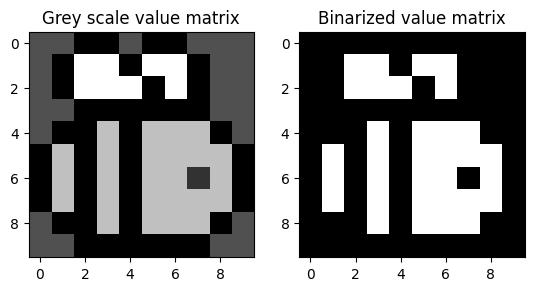

In [6]:
plt.subplot(1, 2, 1)
plt.imshow(test_mat, cmap = 'grey')
plt.title("Grey scale value matrix")
plt.subplot(1, 2, 2)
plt.imshow(test_bin_mat, cmap = 'grey')
plt.title("Binarized value matrix")
plt.show()

## 3) Class representatives

Let's get back to the `MNIST` dataset. This dataset was prepared for a supervised learning task. For each $x \in X_{\text{train}}$ we have a label $y \in Y_{\text{train}}$. We can partition $X_{\text{train}}$ into $|C|$ subsets that correspond to the images for each of the digits ($X^{(1)}$ are all the samples for digit $1$, $X^{(2)}$ for digit $2$, and so on).

$X^{(c)} = \{x \in X_{\text{train}} \mid y = c\}, \text{ with } c \in C = \{0,...9\}$

### 3.a) Compute a representative vector for a given class.
Apply the binary matrix transformations from earlier sections to the training dataset and implement the function body for `compute_class_representative()` that computes a representative value vector (flattened matrix) for a set of input matrices. Then use this function to compute representatives for $c = \{1,3,8\}$.
In this case you can think of the representative value matrix (or vector) as a matrix (or vector) in which each value resembles the probability of the corresponding pixel being white (= a value of 1). This probability is computed given all matrices (or vectors) of that class. You will compute a maximum a posteriori estimate. You may use pseudo-counts if neccessary.


`Note:` For simplicity we assume that pixels in the image data are independent of each other. Can you think of a reason why we do this?

Expected representative matrix: 
[0.441 0.681 0.641 0.601 0.321 0.521 0.401 0.521 0.481 0.561 0.561 0.481
 0.481 0.641 0.481 0.321 0.481 0.521 0.481 0.521 0.441 0.601 0.601 0.401]
Representative matrix with your implementation: 
[0.441 0.681 0.641 0.601 0.321 0.521 0.401 0.521 0.481 0.561 0.561 0.481
 0.481 0.641 0.481 0.321 0.481 0.521 0.481 0.521 0.441 0.601 0.601 0.401]


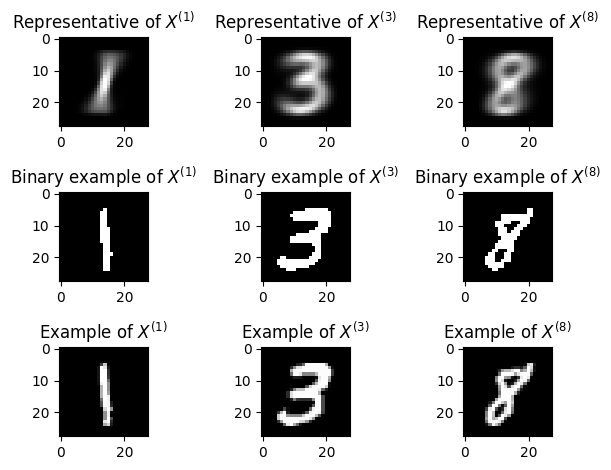

In [7]:
def compute_class_representative(X_c: np.ndarray, pseudo_count = 1e-3):
  """
  Compute a representative value matrix for a set of input matrices.

  Parameters
  ----------
  X_c : np.ndarray
      2D array of binarized input vectors of shape (num_samples, d * d).
  pseudo_count: float
      pseudo count to be added to each pixel value.

  Returns
  -------
  class_representative : np.array
      1D array (n_features,) representing the class representative vector.
  """

  return np.sum(X_c, axis=0) / X_c.shape[0] + pseudo_count

test_X_c = np.random.default_rng(161).integers(0, 2, (25, 24))
test_representative = np.array([0.441, 0.681, 0.641, 0.601, 0.321, 0.521, 0.401, 0.521, 0.481, 0.561, 0.561, 0.481, 0.481, 0.641, 0.481, 0.321, 0.481, 0.521, 0.481, 0.521, 0.441, 0.601, 0.601, 0.401])

print(f"Expected representative matrix: \n{test_representative}")
print(f"Representative matrix with your implementation: \n{compute_class_representative(test_X_c)}")

assert np.array_equal(compute_class_representative(test_X_c), test_representative), "Class representative matrix returned by your implementation is not equal to the expected class representative matrix."

# Once you implemented the function body above, create subsets X_1, X_3, X_8
# from X_train and compute their representative vectors and plot them below. Use
# appropriate transformation to get back to plotable matrix data with correct
# dimensions.

# Apply binarization
X_train_bin = np.array([binarize_image(x) for x in X_train])

# Compute representatives
representative_X_1_vec = compute_class_representative(X_train_bin[Y_train == 1])
representative_X_3_vec = compute_class_representative(X_train_bin[Y_train == 3])
representative_X_8_vec = compute_class_representative(X_train_bin[Y_train == 8])

# Make plotable
representative_X_1_mat = recover_image_matrix(representative_X_1_vec, 28)
representative_X_3_mat = recover_image_matrix(representative_X_3_vec, 28)
representative_X_8_mat = recover_image_matrix(representative_X_8_vec, 28)

# Binarize examples
example_1_X_bin_vec = binarize_image(example_1_X)
example_3_X_bin_vec = binarize_image(example_3_X)
example_8_X_bin_vec = binarize_image(example_8_X)

# Make plotable
example_1_X_bin_mat = recover_image_matrix(example_1_X_bin_vec, 28)
example_3_X_bin_mat = recover_image_matrix(example_3_X_bin_vec, 28)
example_8_X_bin_mat = recover_image_matrix(example_8_X_bin_vec, 28)

plt.subplot(3, 3, 1)
plt.imshow(representative_X_1_mat, cmap = 'grey')
plt.title("Representative of $X^{(1)}$")
plt.subplot(3, 3, 2)
plt.imshow(representative_X_3_mat, cmap = 'grey')
plt.title("Representative of $X^{(3)}$")
plt.subplot(3, 3, 3)
plt.imshow(representative_X_8_mat, cmap = 'grey')
plt.title("Representative of $X^{(8)}$")

plt.subplot(3, 3, 4)
plt.imshow(example_1_X_bin_mat, cmap = 'grey')
plt.title("Binary example of $X^{(1)}$")
plt.subplot(3, 3, 5)
plt.imshow(example_3_X_bin_mat, cmap = 'grey')
plt.title("Binary example of $X^{(3)}$")
plt.subplot(3, 3, 6)
plt.imshow(example_8_X_bin_mat, cmap = 'grey')
plt.title("Binary example of $X^{(8)}$")

plt.subplot(3, 3, 7)
plt.imshow(example_1_X, cmap = 'grey')
plt.title("Example of $X^{(1)}$")
plt.subplot(3, 3, 8)
plt.imshow(example_3_X, cmap = 'grey')
plt.title("Example of $X^{(3)}$")
plt.subplot(3, 3, 9)
plt.imshow(example_8_X, cmap = 'grey')
plt.title("Example of $X^{(8)}$")
plt.tight_layout()
plt.show()

## Computing vector probabilities

#### 3.b) Write a function that computes the log probability for a set of binarized vectors

It will take as input a set of input vectors $X$ you derived from the set of `MNIST` image matrices $X_{\text{test}}$, a class representative $\vec{\mu}_c$. Be careful not to take the logarithm of zero (to avoid that we add a parameter $\varepsilon$ to the function).

Later we can use this to compute for example:

$$
\log \mathbb{P} (\vec{v} \mid y = c) = \sum_{j=1}^{784} v_j\cdot \log(\mu_{c,j}) + (1-v_j)\cdot \log (1-\mu_{c,j})
$$

In [8]:
def log_probabilities(X, class_representative, eps = 1e-7):
    """
    Compute log P(x_i | y=c, theta) for binary X under independent Bernoulli pixels.
    P(x_i | y=c, theta) * P(y=c | theta)   = P(x_i , y=c | theta)

    Parameters
    ----------
    X : array-like, shape (n_samples, d)
        Binary inputs (0/1). If floats, values are interpreted as probabilities but should be 0/1.
    class_representative : array-like, shape (d,)
        Per-pixel probability of 1 (values in [0,1]).
    eps: float
        minimum value for the probability of a pixel to be observed (to avoid rounding errors).

    Returns
    -------
    log_probas : np.ndarray, shape (n_samples,)
        Log-likelihoods for each sample.
    """
    p = np.clip(class_representative, eps, 1.0 - eps)
    #result = np.zeros(X.shape[0])
    # for i in range(X.shape[0]):
        # result[i] = np.sum([ X[i][d] * np.log(p[d]) + (1 - X[i][d]) * np.log(1 - p[d]) for d in range(X.shape[1])] )

    return X @ np.log(p) + (1 - X) @ np.log(1 - p )

test_log_probas = np.array([-87.87645595, -100.75135407, -74.28714557, -82.9868483, -86.35217585, -164.77564207, -79.17198904, -95.40878212])
your_log_probas = log_probabilities(X_train_bin[Y_train == 1][:8], compute_class_representative(X_train_bin[Y_train == 1][:8]))

print(f"Expected log probabilities:\n{test_log_probas}")
print(f"Log probabilities with your implementation:\n{your_log_probas}")

Expected log probabilities:
[ -87.87645595 -100.75135407  -74.28714557  -82.9868483   -86.35217585
 -164.77564207  -79.17198904  -95.40878212]
Log probabilities with your implementation:
[ -89.73446157 -101.45501162  -75.15286271  -83.88452945  -87.11783912
 -165.32545897  -79.95848506  -95.29721671]


In [9]:
from scipy.special import logsumexp

def compute_class_posteriors(X, class_representative_lst, priors_lst):
    """
    Compute class posterior probabilities P(c_k | v_i).

    Parameters
    ----------
    X : list of np.ndarray
        List of samples (binarized vectors), shape (num_samples, d).

    class_representative_lst : list of np.ndarray
        List of class representative vectors, one per class.

    priors_lst : list or np.ndarray
        Class priors P(c_k), should sum to 1.


    Returns
    -------
    posteriors : np.ndarray
        Array of shape (num_samples, num_classes) contining the posterior P(c_k | x_i) for each class c_k and vector v_i
    """

    log_priors = np.log(np.array(priors_lst))
    log_likelihoods = np.zeros((len(X), len(class_representative_lst)))
    # Your code here

    # Compute log P(x_i | C_k) for each class
    for k, class_representative in enumerate(class_representative_lst):
        log_likelihoods[:, k] = log_probabilities(X, class_representative)
    # Add log priors
    log_posteriors_unnormalized = log_likelihoods + log_priors
    # Normalize
    log_posteriors_normalized = log_posteriors_unnormalized - logsumexp(log_posteriors_unnormalized, axis=1, keepdims=True)
    return np.exp(log_posteriors_normalized)


representatives_lst = [representative_X_1_vec, representative_X_3_vec, representative_X_8_vec]
X = np.array([example_1_X_bin_vec, example_3_X_bin_vec, example_8_X_bin_vec])
priors = [0.1, 0.3, 0.6]

class_posteriors = compute_class_posteriors(X, representatives_lst, priors)

expected_class_posteriors = np.array([
    [1.00000000e+00, 1.43676230e-34, 2.25592315e-33],
    [1.36608608e-89, 9.99947360e-01, 5.26398117e-05],
    [8.79971746e-23, 1.49211952e-27, 1.00000000e+00],
  ])

print(f"Expected class posteriors:\n{expected_class_posteriors}")
print(f"Class posteriors with your implementation:\n{class_posteriors}")

Expected class posteriors:
[[1.00000000e+00 1.43676230e-34 2.25592315e-33]
 [1.36608608e-89 9.99947360e-01 5.26398117e-05]
 [8.79971746e-23 1.49211952e-27 1.00000000e+00]]
Class posteriors with your implementation:
[[1.00000000e+00 1.04876255e-34 1.44103679e-33]
 [3.77777612e-87 9.99947174e-01 5.28258115e-05]
 [2.98978657e-22 1.81092191e-27 1.00000000e+00]]


## 3.d) Compute the conditional log-likelihood of the vectors

Compute the conditional log-likelihood of the vectors by integrating over all possible class membership (note that you will have to compute an exponential of the log-probabilities computed with the previous function, again the log-sum-exp transformation might come in handy here).
$$
\log P(x_1,\ldots, x_n \mid (c_1, \ldots, c_K), (\mu_1, \ldots, \mu_K), (\pi_1,\ldots, \pi_K)) =
\sum_{i=1}^n \log \Big(\sum_{k=1}^K \pi_k P(x_i \mid z_i = k)\Big)
$$
`Note:` $z_i$ is the latent (non observed) variable that corresponds to the class of the vector $x_i$

In [63]:
def conditional_log_likelihood(X, class_representative_lst, priors_lst):
    """
    Compute the conditional log-likelihood of each vector x_i
    by marginalizing over all class memberships.

    Parameters
    ----------
    X : list of np.ndarray
        List of samples (binarized vectors), shape (num_samples, d).

    class_representative_lst : list of np.ndarray
        List of class representative vectors (means for each class).

    priors_lst : list or np.ndarray
        Class prior probabilities P(C_k), should sum to 1.

    Returns
    -------
    cond_log_likelihood : np.ndarray
        1D array of conditional log-likelihoods log P(x_i) for each sample.
    """

    log_props = np.array([ log_probabilities(X, class_representative, eps = 1e-7) for class_representative in class_representative_lst ]) # (k, n_samples)

    # Your code here
    log_priors = np.log(np.array(priors_lst)).reshape(len(priors_lst),1)
    # log_likelihoods = np.zeros((len(X), len(class_representative_lst)))
    return logsumexp(log_props + log_priors, axis=0)


cond_log_likelihood = conditional_log_likelihood(X, representatives_lst, priors)

expected_cond_log_likelihood = np.array([ -87.52055809, -178.60050244, -158.62268905])


print(f"Expected conditional log-likelihoods:\n{expected_cond_log_likelihood}")
print(f"Conditional log-likelihoods with your implementation:\n{cond_log_likelihood}")



Expected conditional log-likelihoods:
[ -87.52055809 -178.60050244 -158.62268905]
Conditional log-likelihoods with your implementation:
[ -87.64876484 -178.45900635 -158.64885777]


## 4) Estimating class representatives and implementing EM _light_

In the following we will implement a simplified version of EM with binary class allocations (each sequence is in the class where it has the highest posterior probability).

We will first write a function for the E-step, then a function for the M-step, and finally combine them to EM-light.


#### 4.a) Write a function for computing the E-step of the EM algorithm

From set of vectors, class representatives and priors, we compute first compute the class posteriors and then assign clusters to the input vectors. Then compute the conditional log likelihood to track convergence.



In [64]:
def E_step(X, class_representatives_lst, priors_lst):
    """
    Performs the E-step of a simplified EM lite algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features), where each row is a flattened observation.
    representatives : list of np.ndarray
        Current class representative vectors (means or prototypes).
    priors : np.ndarray
        Current class prior probabilities, shape (n_classes,).

    Returns
    -------
    assignments : np.ndarray
        Hard class assignments (argmax over posterior probabilities), shape (n_samples,).
    cond_log_likelihood : np.ndarray
        Conditional log-likelihoods log P(X), shape (n_samples,).
    """
    # technically this returns e^x our value but it does not matter since e^x is strictly increasing
    q = compute_class_posteriors(X, class_representatives_lst, priors_lst )
    # Hard assign
    y = np.argmax(q, axis=1)

    # For tracking convergence
    return y, conditional_log_likelihood(X, class_representatives_lst, priors_lst)


assignments, cond_log_likelihoods = E_step(X, representatives_lst, priors)

#### 4.b) Write a function for computing the M-step of the EM algorithm

From set of vectors, cluster assignments from the E-step, and a given number of clusters K, update the class representatives and priors.



In [65]:
assignments

array([0, 1, 2])

In [66]:
def M_step(X, assignments, K):
    """
    Performs the M-step of the simplified EM algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features), where each row is a flattened observation.
    assignments : np.ndarray
        Hard class assignments (output of E-step), shape (n_samples,).
    K : int
        Number of classes (clusters).

    Returns
    -------
    representatives : list of np.ndarray
        Updated class representatives (mean vectors for each class).
    priors : np.ndarray
        Updated class prior probabilities (frequency of each class).
    """
    new_representative = np.array([compute_class_representative(X[assignments == i]) for i in range(K)])

    new_priors = np.bincount(assignments, minlength=K) / len(X)

    return new_representative, new_priors


class_representatives_lst, priors_lst = M_step(X, assignments, 3)


In [67]:
class_representatives_lst.shape

(3, 784)

#### 4.c) Implementing EM

We will implement the EM algorithm with fixed class allocation:

1. Fix the number of clusters $K$. In the next part, we first will try two values: $K=10$ and $K=20$.
2. Initialize random allocation of the representative. The most common way is to sample the $K$ representative from the set of points at random, however you can also use e.g.: `kmeans++` for better initialization, which can lead to faster convergence (there are some libraries implementing `kmeans++` that you can use).
3. Until convergence
    - run E-step
    - run M-step (update representatives and priors)
    - check if convergence criteria is met (change in max nll or min ll is smaller than tolerance threshold `tol`) or maximum number of iterations it reached





In [103]:
from sklearn.cluster import kmeans_plusplus
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

def EM(X, K, max_iter=100, tol=1e-4):
    """
    Simplified EM (hard assignment) algorithm.

    Parameters
    ----------
    X : np.ndarray
        Data matrix of shape (n_samples, n_features).
    K : int
        Number of classes.
    max_iter : int, optional
        Maximum number of EM iterations.
    tol : float, optional
        Convergence tolerance for change in log-likelihood.

    Returns
    -------
    class_representatives_lst : list of np.ndarray
        Estimated class representative vectors.
    priors : np.ndarray
        Estimated class priors.
    assignments : np.ndarray
        Hard assignments for each sample.
    log_likelihoods : list of float
        Log-likelihood at each iteration.
    """

    # Init
    rng = np.random.default_rng(seed=42)
    init_indices = rng.choice(len(X), K, replace=False)
    L = 1
    class_representatives_lst = [X[i] for i in init_indices]

    priors_lst = np.ones(K) / K
    lls = []
    new_ll = 0
    #print(init_indices)
    while L >= tol and len(lls) < max_iter:
        """clear_output(wait=True)

        num_to_show = min(100, K)   # show up to 3 classes
        fig, axes = plt.subplots(1, num_to_show, figsize=(3*num_to_show, 3))

        if num_to_show == 1:
            axes = [axes]  # ensure iterable

        for k in range(num_to_show):
            ax = axes[k]
            matrix_k = recover_image_matrix(class_representatives_lst[k], 28)
            ax.imshow(matrix_k, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Class {k}', fontsize=10)

        fig.suptitle(f'EM convergence - iteration {c}', fontsize=14)
        plt.tight_layout()
        plt.show()"""

        assignments, new_ll = E_step(X, class_representatives_lst, priors_lst)
        class_representatives_lst, priors_lst = M_step(X, assignments, K)

        lls.append(new_ll)
        L =  tol if (len(lls) <= 1) else abs(np.min(lls[-1]) - np.min(lls[-2]))

    return class_representatives_lst, priors_lst, assignments, lls
K_1 = 10
K_2 = 20
N = 6000

class_representatives_lst_10, priors_lst_10, assignments_10, log_likelihoods_10 = EM(X_train_bin[:N], K_1)


In [83]:
log_likelihoods_10

[np.float64(-8892503.534130974),
 np.float64(-1052635.3452802012),
 np.float64(-1016247.7577923024),
 np.float64(-1003496.9066192308),
 np.float64(-997596.3192381491),
 np.float64(-993955.2047655145),
 np.float64(-990718.8066385636),
 np.float64(-988760.2447140444),
 np.float64(-987680.9994011634),
 np.float64(-987030.9010558662),
 np.float64(-986602.987509008),
 np.float64(-986341.4831192216),
 np.float64(-986208.8411363016),
 np.float64(-986139.2668617817),
 np.float64(-986099.6739290751),
 np.float64(-986068.9279381571),
 np.float64(-986059.9165267121),
 np.float64(-986057.617057808),
 np.float64(-986054.4233735637),
 np.float64(-986048.5758694028),
 np.float64(-986048.5758694028)]

## 5) Evaluation

Evaluating the quality of a clustering is always a complex task. In the case of the digit data, we can compare it to the digit allocation in order to assess if some clusters are better defined than others.

In this part we will perform some simple evaluation and visualization for the typical clustering we obtained in the previous part (*e.g.* with $K=10$ and $K=20$ clusters).

One measure that can be computed in the case where class membership are available is the **purity**. The purity is a measure of how much of a cluster describes a single class. It is defined for each cluster $C_k$ as the proportion accounted by the majority class.
$$
\text{purity}(C_k) = \frac{1}{C_k}\; \max_{c=0,\ldots, 9} \quad \sum_{i=1}^{n} \mathbb{I}\{x_i \in C_k; y_i = c\}
$$


### 5.a) Plot the representative for each cluster
- How does the representatives looks like for $K=10$ clusters? Is it a sufficient number of clusters? How can you explain that?
- In the case of $K=20$, do you see any digits that seem to be spread across multiple cluster? How do you explain that?



In [70]:
#TODO do this for K=20 as well

In [71]:
counts = np.bincount(Y_train[:N])
print(counts / sum(counts) * 100)

[ 9.86666667 11.18333333  9.68333333 10.13333333 10.38333333  8.56666667
 10.13333333 10.85        9.18333333 10.01666667]


/tmp/ipython-input-2838580174.py:7: UserWarning:

The figure layout has changed to tight



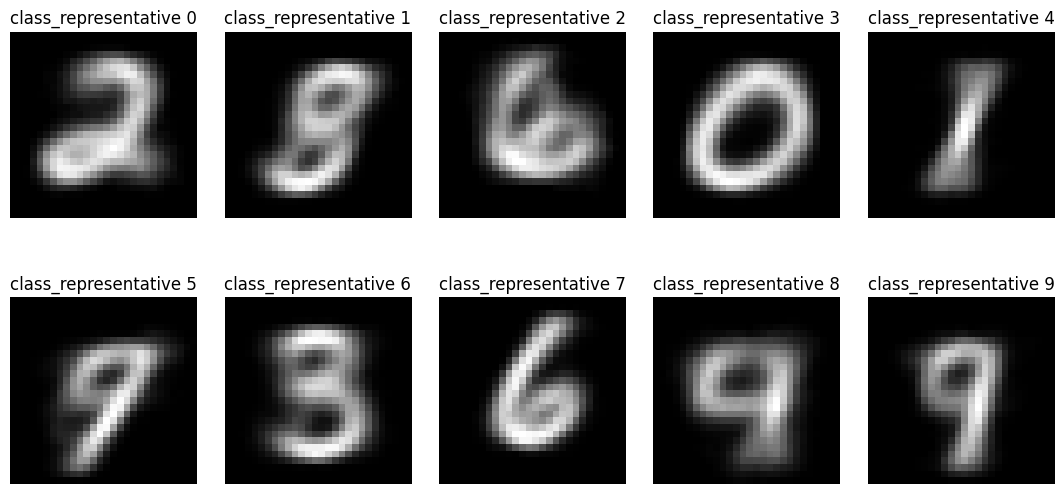

In [72]:

fig, axes = plt.subplots(2, 5, figsize=(11, 6), constrained_layout=True)
for x in range(2):
    for y in range(5):
        axes[x, y].imshow(recover_image_matrix(class_representatives_lst_10[x*5 + y]), cmap='gray')
        axes[x, y].set_title("class_representative "+ str(x*5 + y))
        axes[x, y].axis('off')
plt.tight_layout(pad=2.0)
plt.show()

### 5a_1
The representatives resemble non-binarized images from the digit dataset. However, some of the digits appear to be missing, and others seem to appear multiple times. Therefore, they do not match the 10 representatives that can be computed from the labeled data.

The number of clusters seems insufficient, since some digits present in the dataset are not recognizable in the computed representatives. We identify two reasons for this result.
First, the outcome probably depends strongly on the initial class representatives. If a digit is initially not represented, it will be distributed among the other clusters. This leads to a local maximum that the algorithm fails to escape.
Second, some samples might have more in common with samples from other classes than with samples from their own class. For example, a skewed 3 might be closer to a skewed 8 than to a straight 3.

The fact that digits are spread across multiple clusters can again be linked to the two ideas explained above. If an initial representative maps to two samples of the same digit, it is more likely that the remaining samples of that digit will be divided according to the differences between these two initial representatives, rather than one representative slowly converging toward the other (this is probably caused by taking the maximum for the q-values instead of weighting based on q as in the geyser project). Additionally, the intra-class variance might be very high. After all, the highest likelihood would be achieved if each sample had its own cluster.

In [73]:
counts = np.bincount(assignments)
print(counts / sum(counts) * 100)

[33.33333333 33.33333333 33.33333333]


In [74]:
class_representatives_lst_20, priors_lst_20, assignments_20, log_likelihoods_20 = EM(X_train_bin[:N], K_2)

/tmp/ipython-input-174060620.py:7: UserWarning:

The figure layout has changed to tight



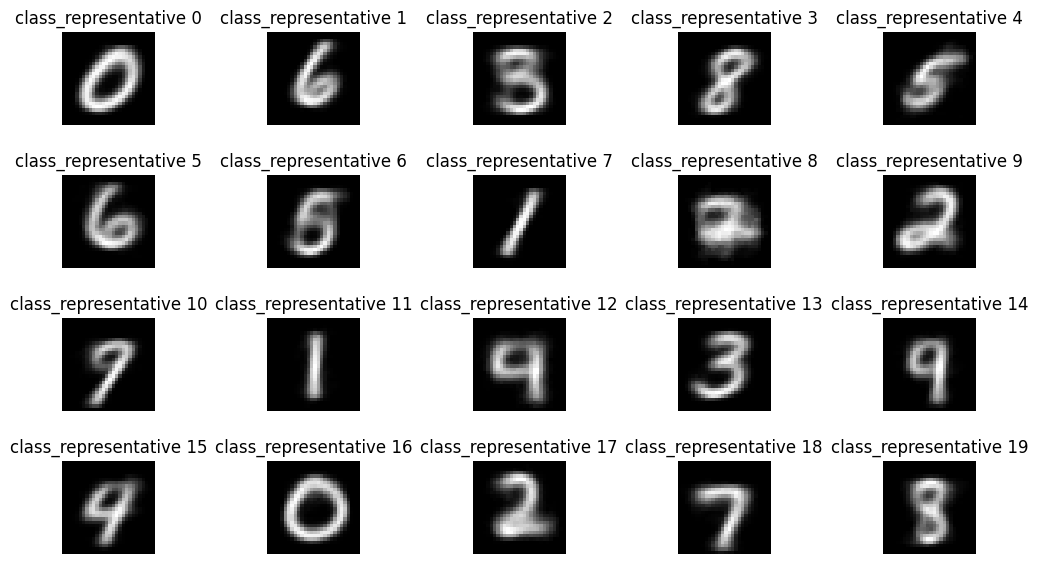

In [75]:

fig, axes = plt.subplots(4, 5, figsize=(11, 6), constrained_layout=True)
for x in range(4):
    for y in range(5):
        axes[x, y].imshow(recover_image_matrix(class_representatives_lst_20[x*5 + y]), cmap='gray')
        axes[x, y].set_title("class_representative "+ str(x*5 + y))
        axes[x, y].axis('off')
plt.tight_layout(pad=2.0)
plt.show()



### 5.b) Compute the purity for each cluster

For both $K=10$ and $K=20$, look at the clusters that get the best or the worst purity.
- Are they associated with particular digits?
- How could you explain that?

Cluster 19: purity=0.385, size=366
Cluster 14: purity=0.443, size=384
Cluster 8: purity=0.448, size=154
Cluster 2: purity=0.493, size=292
Cluster 12: purity=0.502, size=231
Cluster 6: purity=0.516, size=285
Cluster 10: purity=0.565, size=409
Cluster 4: purity=0.608, size=316
Cluster 15: purity=0.623, size=393
Cluster 11: purity=0.827, size=375
Cluster 3: purity=0.843, size=325
Cluster 17: purity=0.903, size=267
Cluster 9: purity=0.924, size=223
Cluster 5: purity=0.925, size=214
Cluster 18: purity=0.927, size=289
Cluster 13: purity=0.929, size=283
Cluster 1: purity=0.952, size=357
Cluster 0: purity=0.961, size=282
Cluster 16: purity=0.961, size=207
Cluster 7: purity=0.963, size=348
ARI: 0.3773136587938487


/tmp/ipython-input-1980289926.py:37: UserWarning:

The figure layout has changed to tight



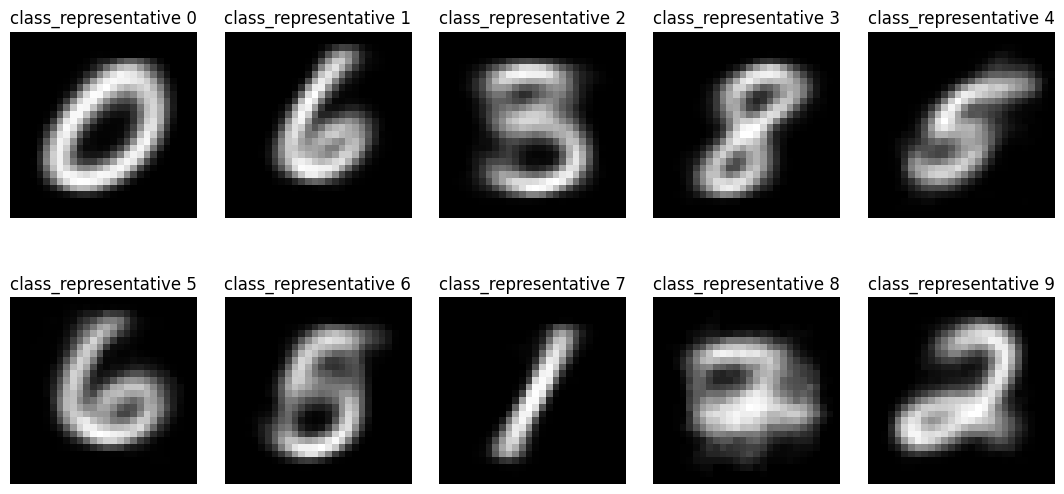

In [76]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix


def per_cluster_purity(y_true, y_pred):
    yp_unique, yp_idx = np.unique(y_pred, return_inverse=True)
    y_unique,  y_idx  = np.unique(y_true, return_inverse=True)

    K1 = len(yp_unique)
    K2 = len(y_unique)

    M = np.zeros((K1, K2), dtype=int)
    np.add.at(M, (yp_idx, y_idx), 1)

    cluster_sizes = M.sum(axis=1)
    max_class = M.argmax(axis=1)
    purity = M[np.arange(K1), max_class] / cluster_sizes

    return purity, cluster_sizes

Ks = [10, 20]
purity, sizes = per_cluster_purity(Y_train[:N], assignments_20)
wrapped = enumerate(zip(purity, sizes))
wrapped = sorted(wrapped, key=lambda x: x[1])
for j, (p, n) in wrapped:
    print(f"Cluster {j}: purity={p:.3f}, size={n}")

ari = adjusted_rand_score(Y_train[:N], assignments_20)
print(f"ARI: {ari}")


fig, axes = plt.subplots(2, 5, figsize=(11, 6), constrained_layout=True)
for x in range(2):
    for y in range(5):
        axes[x, y].imshow(recover_image_matrix(class_representatives_lst_20[x*5 + y]), cmap='gray')
        axes[x, y].set_title("class_representative "+ str(x*5 + y))
        axes[x, y].axis('off')
plt.tight_layout(pad=2.0)
plt.show()

In [77]:
def cluster_confusion_matrix(assignments1, assignments2):
    a1_unique, a1_idx = np.unique(assignments1, return_inverse=True)
    a2_unique,  a2_idx  = np.unique(assignments2, return_inverse=True)

    M = np.zeros((len(a1_unique), len(a2_unique)), dtype=int)
    np.add.at(M, (a1_idx, a2_idx), 1)

    return M, a1_unique, a2_unique


Cluster 9: purity=0.283, size=601
Cluster 5: purity=0.374, size=514
Cluster 4: purity=0.393, size=623
Cluster 7: purity=0.412, size=651
Cluster 2: purity=0.415, size=581
Cluster 3: purity=0.433, size=608
Cluster 0: purity=0.458, size=592
Cluster 8: purity=0.497, size=551
Cluster 1: purity=0.499, size=671
Cluster 6: purity=0.559, size=608
ARI: 0.3773136587938487


/tmp/ipython-input-4079586263.py:31: UserWarning:

The figure layout has changed to tight



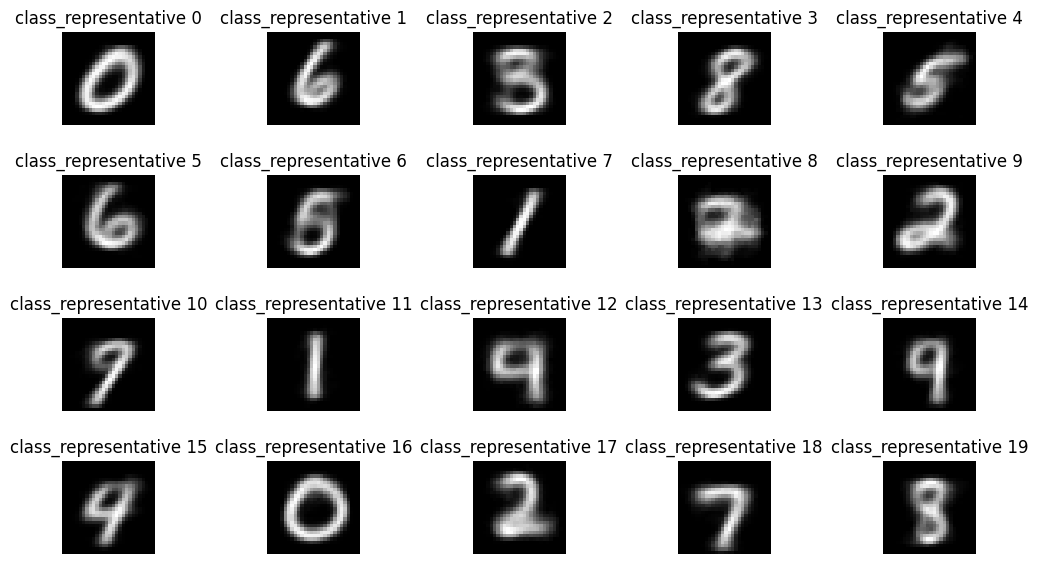

In [78]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix


def per_cluster_purity(y_true, y_pred):

    M, true_unique_lables, pred_unique_lables = cluster_confusion_matrix(y_true, y_pred)

    cluster_sizes = M.sum(axis=1)
    max_class = M.argmax(axis=1)
    purity = M[np.arange(len(true_unique_lables)), max_class] / cluster_sizes

    return purity, cluster_sizes


purity, sizes = per_cluster_purity(Y_train[:N], assignments_20)
wrapped = enumerate(zip(purity, sizes))
wrapped = sorted(wrapped, key=lambda x: x[1])
for j, (p, n) in wrapped:
    print(f"Cluster {j}: purity={p:.3f}, size={n}")

ari = adjusted_rand_score(Y_train[:N], assignments_20)
print(f"ARI: {ari}")


fig, axes = plt.subplots(4, 5, figsize=(11, 6), constrained_layout=True)
for x in range(4):
    for y in range(5):
        axes[x, y].imshow(recover_image_matrix(class_representatives_lst_20[x*5 + y]), cmap='gray')
        axes[x, y].set_title("class_representative "+ str(x*5 + y))
        axes[x, y].axis('off')
plt.tight_layout(pad=2.0)
plt.show()

A lot of the classes with lower purity combine similar numbers into a single class and representative. For example there are multiple classes that combine a digits of images of four, seven and nine like the class 8/10 (meaning the class with lable 8 in the clustering with 10 classes) and the classes 14/20 and 12/20. Each of these has a purity of ~0.5 or lower likely, because it contains images form these two digits. Similarly the images of tree, five and eight are often sortet into the same class. For example 1/10 and 6/10 as well as 19/20 and 2/20, each with a purity of less than 0.5. This is because the numbers are quite similar in a pixel representation. For example the nine can be turned into a four by removing the top line and into a seven by removing a part of the loop.

On the other end of the spectrum, classes representing zero and one are usually quite pure, because they have few intersections with other numbers. The zero has a wider curve than all other numbers and the one is special, because no other number has a line down the center. For examle the classes 3/10,  0/20 and 16/20 represent zero and all have a purity that is larger than ~9.5 and the classes 4/10, 7/20 and 11/20 represent one and all have a purity of above 0.8.

## 5.c) Using Sankey Plot

[Sankey plots](https://en.wikipedia.org/wiki/Sankey_diagram) can summarize visually how globally digit identity are spread around clusters. Create a Sankey plot that matches the digits labels to the cluster allocation. In other words we will show how the digits (labelled from the _ground truth_ `Y_train`) flow into the different clusters. You can limit yourself to the case of $K=20$ for this representation.

 - Consider one of the clusters with the highest purity, can you see it in the Sankey plot?
 - Is there a digit that is reliably represented by only one cluster?
 - If not how many clusters are needed at minimum to represent all instances of a digit? Which digits are concerned in that case?

In [79]:
## Plotly provides the easiest method for obtaining sankey plot with interactive visualization
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'colab'


def sanky_yanky(y_true, assignments_oK, assignments_20=None):

    y_true = np.array(y_true)
    cluster_oK_assignments = np.array(assignments_oK)
    cluster_20_assignments = np.array([])
    if assignments_20 is not None:
        cluster_20_assignments = np.array(assignments_20)

    true_labels = [f"Label {t}" for t in np.unique(y_true)]
    cluster_oK_labels = [f"Cluster_{cluster_oK_assignments.shape[0]} {c}" for c in np.unique(cluster_oK_assignments)]
    cluster_20_labels = [f"Cluster_{cluster_20_assignments.shape[0]} {c}" for c in np.unique(cluster_20_assignments)]
    all_labels = true_labels + cluster_oK_labels + cluster_20_labels


    counts1 = cluster_confusion_matrix(y_true, assignments_oK)[0]
    counts2 = cluster_confusion_matrix(assignments_oK, assignments_20)[0]


    sources = []
    targets = []
    values  = []

    for i in range(len(true_labels)):
        for j in range(len(cluster_oK_labels)):
            v = counts1[i, j]
            if v > 0:
                sources.append(i)
                targets.append(len(true_labels) + j)
                values.append(v)
    for i in range(len(cluster_oK_labels)):
        for j in range(len(cluster_20_labels)):
            v = counts2[i, j]
            if v > 0:
                sources.append(len(true_labels) + i)
                targets.append(len(true_labels) + len(cluster_oK_labels) + j)
                values.append(v)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            label=all_labels,
            pad=15,
            thickness=20
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values
        )
    )])

    fig.update_layout(title_text="True labels → Cluster assignments", font_size=10)
    fig.show()

    return sources, targets, values

s, t, v =sanky_yanky(Y_train[:6000], assignments_10)

## 6. The agony of choice (for a good $K$)

In this part we will see how we can use measures such as dispersion of likelihood to decide a good number of clusters $K$.

#### 6.a) Find a good number of clusters computationally.

The negative log likelihood (`nll`) and / or the within-cluster variance can be good indicators to select the number of cluster. We will consider different values of $k$ (from 2 to 20) and monitor how the `nll` or the variance changes. We will also see how the number of cluster affect the runtime of the EM-light algorithm.  Plot and describe your findings.

- Run the mixture model for different values of $k$ from $2$ to $20$ or more and plot the `nll` as a function of $k$. Plot as well the running time of EM as a function of $k$.
- Propose the best value for $k$, justify your choice. What about the resulting groups, are they very diverse?

#### 6.b) Comparing the best results

Using a Sankey plot with 3 components, represent the class allocation together with the clustering of the best value of $K$ and a value of $K=20$.

In [80]:
#TODO interpret results

In [81]:
import time
max_nll_lst, time_lst = [], []

Kmax = 20
for K in range(1, Kmax + 1):
    start_time = time.time()
    class_representatives_lst, priors_lst, assignments, log_likelihoods = EM(X_train_bin[:N], K)
    end_time = time.time()
    max_nll = -log_likelihoods[-1] / N
    max_nll_lst.append(max_nll)
    time_lst.append(end_time - start_time)
    print(f"K={K}, Max NLL={max_nll:.3f}, Time={end_time - start_time:.2f} sec")

K=1, Max NLL=0.068, Time=0.31 sec
K=2, Max NLL=0.060, Time=6.10 sec
K=3, Max NLL=0.062, Time=7.30 sec
K=4, Max NLL=0.068, Time=14.84 sec
K=5, Max NLL=0.067, Time=22.66 sec
K=6, Max NLL=0.072, Time=27.75 sec
K=7, Max NLL=0.065, Time=18.57 sec
K=8, Max NLL=0.066, Time=30.09 sec
K=9, Max NLL=0.061, Time=17.22 sec
K=10, Max NLL=0.064, Time=12.16 sec
K=11, Max NLL=0.066, Time=15.68 sec
K=12, Max NLL=0.064, Time=21.70 sec
K=13, Max NLL=0.067, Time=31.00 sec
K=14, Max NLL=0.059, Time=22.69 sec


KeyboardInterrupt: 

In [104]:
import time

def evaluate_different_Ks(X, Kmax=20, samplesize=1):
    nll_lst, time_lst = [], []

    nll_samples = np.zeros(samplesize)
    time_samples = np.zeros(samplesize)
    for i in range(2,Kmax):
        for c in range(samplesize):
            start = time.perf_counter()
            cl, priors, assignments, ll = EM(X, i)
            end = time.perf_counter()
            nll_samples[c] = -np.average(ll[-1])
            time_samples[c] = end - start
        nll_lst.append(np.median(nll_samples))
        time_lst.append(np.median(time_samples))
        print(f"K={i}, Max NLL={np.median(nll_samples):.3f}")

    return nll_lst, time_lst

In [ ]:
#this took 5 min in our machine
nll_lst, time_lst = evaluate_different_Ks(X=X_train_bin[:N], Kmax=15)

K=2, Max NLL=195.485
K=3, Max NLL=188.005
K=4, Max NLL=182.889
K=5, Max NLL=177.776
K=6, Max NLL=173.696


In [100]:
fig = go.Figure(data=go.Scatter(x=[i for i in range(2,20)], y=nll_lst, mode='lines+markers'))
fig.update_layout(
    title="Max NLL vs. Number of Clusters",
    xaxis_title="i (2 to 19)",
    yaxis_title="max_nll"
)

fig.show()

In [101]:
max_nll_lst
fig = go.Figure(data=go.Scatter(x=[i for i in range(2,20)], y=time_lst, mode='lines+markers'))
fig.update_layout(
    title="Max NLL vs. Number of Clusters",
    xaxis_title="i (2 to 19)",
    yaxis_title="max_nll"
)

fig.show()

In [ ]:
optimal_K = 16
_, _, assignments_20, _ = EM(X_train_bin[:6000], 20)
_, _, assignments_oK, _ = EM(X_train_bin[:6000], optimal_K)

In [ ]:
s, t, v = sanky_yanky(y_true=Y_train[:6000], assignments_oK=assignments_20, assignments_20=assignments_oK)

## 7) Data Imputation
### Oh no! Part of the image got overwritten with `512` values! Can we recover the digit pictured on the image with our trained mixture model?

As we saw during the lecture, clustering is also a way of producing simplified representations of the data points (albeit somehow crude). We will see in the following if we can use the information in the representative to reconstruct part of the image that would have been masked.

Below you will find our example image vectors, each masked with `512`s for some predetermined positions between pixels 100 and 400. This leaves us with some visible pixels $x_{vis}$ and some 'missing' (masked) pixels $x_{miss}$.

We want to compute a probability for the image to below of each of the class, given the visible pixels $x_{vis}$. Then, we can reconstruct each pixel as a posterior value over all possible class allocations.

1. Implement the function `em_impute`, that computes the posterior probabilities to belong to each class $c$ given the visible pixels of the image, given the results of the EM-lite run:

$$
p(z = c \mid x_{vis})
$$

2. Then for each missing pixel $x_j$ impute its expected value given the model parameters we trained:
$$
\mathbb{E}[x_j \mid x_{vis}] = \sum_{k=1}^{K}p(z = c_k \mid x_{vis})\cdot \mu_{k,j}
$$

1. (optional) Imagine we want to consider those 3 images with missing pixel for the estimation of the parameters. Is it possible to write a version of the EM algorithm that would take into account those images with missing values? What are the changes for the E-step and the M-step in that case?


#### 7.a) Implement `em_impute()` that takes a masked image vector, the respective mask, a set of representatives and a set of priors as input and outputs a recovered image vector with imputed values at the positions of the mask.

#### 7.b) Plot the imputed images for example 1,3, and 8 with `mask1` and `mask2` respectively. Comment on the quality of the reconstruction depending on the digit and the mask used. How would you assess the quality of the reconstruction in a more systematic way?


`Note:` You might want to make use of `log_probabilities()`, `compute_class_posteriors()`, and `binarize_image()` functions again.
Can you get away without calling `binarize_image()`? What do you observe?

In [ ]:

from matplotlib.colors import ListedColormap, BoundaryNorm

example_1_masked = example_1_X_bin_vec.copy().astype('uint16')
example_3_masked = example_3_X_bin_vec.copy().astype('uint16')
example_8_masked = example_8_X_bin_vec.copy().astype('uint16')
mask1 = np.ones(len(example_1_X_bin_vec), dtype = bool)
mask2 = np.ones(len(example_1_X_bin_vec), dtype = bool)
mask1[200:400] = False
mask2[200:600] = False
example_1_masked[~mask1] = 512
example_3_masked[~mask1] = 512
example_8_masked[~mask1] = 512

cmap = ListedColormap(['black', 'white', 'red'])
norm = BoundaryNorm([0, 0.5, 1.5, 512.5], cmap.N)

plt.subplot(1,3,1)
plt.imshow(recover_image_matrix(example_1_masked), cmap = cmap, norm=norm)
plt.subplot(1,3,2)
plt.imshow(recover_image_matrix(example_3_masked), cmap = cmap, norm=norm)
plt.subplot(1,3,3)
plt.imshow(recover_image_matrix(example_8_masked), cmap = cmap, norm=norm)
plt.show()

In [ ]:
plt.imshow(recover_image_matrix(example_1_masked), cmap = cmap,norm=norm)

In [ ]:
def em_impute(x_masked, mask, class_representatives, class_priors, K = 10):
    """
    Imputes missing (masked) pixels in x_masked using parameters retrived by EM-light.

    Parameters
    ----------
    X_masked : np.ndarray, shape (num_samples, d)
        Each row is a flattened image (some pixels missing or zeroed)
    mask : np.ndarray, shape (d,)
        Boolean array: True for observed pixels, False for missing ones
    class_representatives : np.ndarray, shape (K, d)
        Mean vectors estimated by EM (μ_k)
    class_priors : np.ndarray, shape (K,)
        Prior probabilities for each class (π_k)

    Returns
    -------
    X_imputed : np.ndarray, shape (n_samples, d)
        Reconstructed images with missing pixels imputed.
    """

    class_representatives = np.array(class_representatives)
    x_masked = np.array(x_masked).astype(float)

    # Visible pixels
    x_vis = x_masked[mask]
    class_representatives_vis = class_representatives[:, mask]
    # log_props_vis = log_probabilities(x_vis, class_representative=class_representatives_vis)
    posteriors = compute_class_posteriors(x_vis.reshape((1, x_vis.shape[0])), class_representatives_vis, class_priors)

    result = posteriors @ class_representatives  # d,k x k = d, 1

    c = np.where(mask, x_masked, result)
    return binarize_image(c*255)


#TODO:???class_representatives_lst, priors_lst, assignments, log_likelihoods
example_1_imputed = em_impute(example_1_masked, mask1, class_representatives_lst, priors_lst, K = 20)
example_3_imputed = em_impute(example_3_masked, mask1, class_representatives_lst, priors_lst, K = 20)
example_8_imputed = em_impute(example_8_masked, mask1, class_representatives_lst, priors_lst, K = 20)

plt.imshow(example_3_X_bin_mat, cmap = 'grey')


In [ ]:
plt.imshow(recover_image_matrix(example_3_masked), cmap = 'grey')

### 7.3. Imagine we want to consider those 3 images with missing pixel for the estimation of the parameters. Is it possible to write a version of the EM algorithm that would take into account those images with missing values? What are the changes for the E-step and the M-step in that case?
Yes it is possible to consier masked images in the EM algorithm. In the E-Step the posteriors for the incomplete images, by only considering the pixels for which we have values to compute the log posterios
$
\log P(x_j \mid (c_1, \ldots, c_K), (\mu_1, \ldots, \mu_K), (\pi_1,\ldots, \pi_K)) =
\log \Big(\sum_{k=1}^K \pi_k P(x_i \mid z_i = k)\Big)
$
the sum would than only go over the values for which we have values.
This could be implemented in the same way as we did it for em_impute(), by cutting the masked section form both the masked image and the representative and than using compute_class_posteriors() as usual. Only using a subset of the pixels would result in thease images having on avrage a higer likelihood than the complete images, but since we only use the posterior, which is normalized, and only compare the class posteriors to other class posteriors of the same image, this should not be a problem.


For the M-Step we would similarly only consider the pixels with a known value to compute the new class representative. This could be implemented by frist, setting all unknown values to 0 then computing the sum of all images assigned to the class as usual, and finally deviding each pixel of the resulting sum-image by the number of known pixels at that position over all images.

## 7) One size _fits_ all? (Bonus)

Enough with all these numbers and digits! Around 2018, Zalando research proposed a new [`fashion-MNIST`](https://github.com/zalandoresearch/fashion-mnist) dataset which consider images of fashion items. This dataset contains as well 10 classes and 60,000 examples.It can be easily imported from the `keras` package.

- Load the dataset and see how our model works on this dataset too!
  - What is the effect of the binarization of the images in part 2?
  - You can go over parts 4.c) to 6) on this dataset and analyze the results.
- Does the Bernoulli mixture fits to this dataset?
- Do you have to retrain the model parameters? What do you see?


(60000, 28, 28)

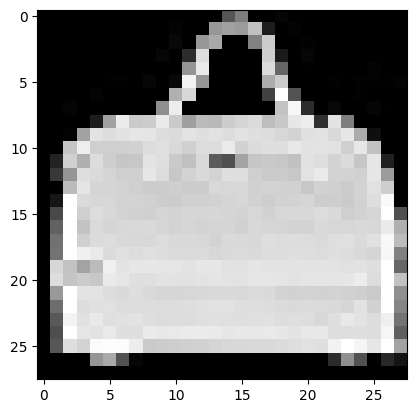

In [90]:
from keras.datasets import fashion_mnist

(F_train, E_train), (test_F, test_e) = fashion_mnist.load_data()

# You code here

example_Fashion = F_train[220]

plt.imshow(example_Fashion, cmap = 'grey')
F_train.shape

### What is the effect of the binarization of the images in part 2?
We loose most information about the texture of the object. With a low thrashold we only get the outlines of the object. A higher thrashold might allow you to perserve a little bit of the objecsts texture, but at the price of loosing entire elements of object. For example, in the grafik below, a thrashold of 127 perserves the buckle of the first bag, but looses almost the entire strap of the second bag, while a thrashold of 127 perserves the outline of both images, but looses all information about the internal texture.  


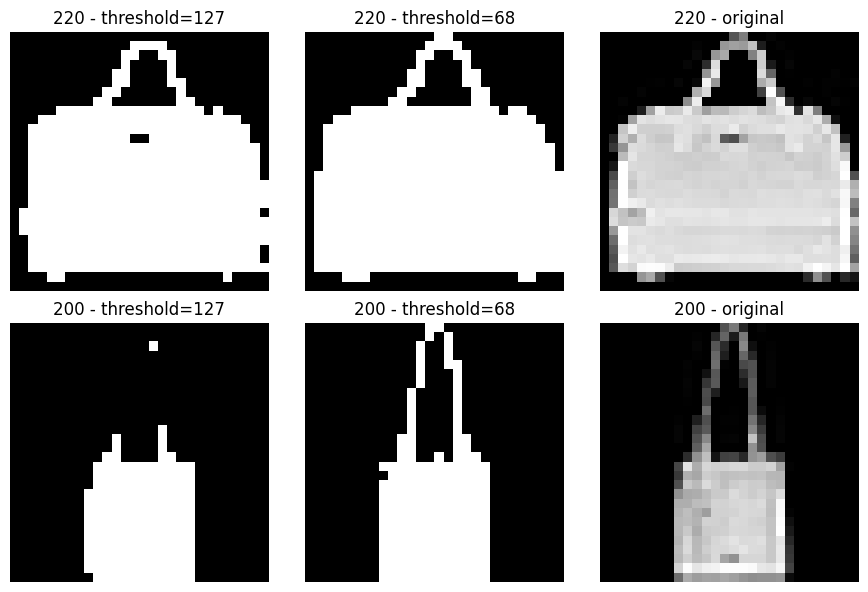

In [91]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(9, 6))

axes[0, 0].imshow(recover_image_matrix(binarize_image(F_train[220])), cmap='gray')
axes[0, 0].set_title("220 - threshold=127")
axes[0, 0].axis('off')

axes[0, 1].imshow(recover_image_matrix(binarize_image(F_train[220], threshold=68)), cmap='gray')
axes[0, 1].set_title("220 - threshold=68")
axes[0, 1].axis('off')

axes[0, 2].imshow(recover_image_matrix(F_train[220]), cmap='gray')
axes[0, 2].set_title("220 - original")
axes[0, 2].axis('off')

axes[1, 0].imshow(recover_image_matrix(binarize_image(F_train[200])), cmap='gray')
axes[1, 0].set_title("200 - threshold=127")
axes[1, 0].axis('off')

axes[1, 1].imshow(recover_image_matrix(binarize_image(F_train[200], threshold=68)), cmap='gray')
axes[1, 1].set_title("200 - threshold=68")
axes[1, 1].axis('off')

axes[1, 2].imshow(recover_image_matrix(F_train[200]), cmap='gray')
axes[1, 2].set_title("200 - original")
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


# Estimating class representatives and implementing EM light

In [92]:
F_train_bin = np.array([binarize_image(x) for x in F_train])

repr, priors, assignments, lls = EM(F_train_bin[:N], 20)

# Evaluation

In [102]:
for i in range(20):
    plt.subplot(4,5, i+1, figsize=(10,10)
    mat = recover_image_matrix(repr[i])
    plt.imshow(mat, cmap = 'grey')
    plt.title(f"Class {i}")

SyntaxError: '(' was never closed (ipython-input-1148191994.py, line 2)

In [94]:
purity, sizes = per_cluster_purity(E_train[:N], assignments)
wrapped = enumerate(zip(purity, sizes))
wrapped = sorted(wrapped, key=lambda x: x[1])
for j, (p, n) in wrapped:
    print(f"Cluster {j}: purity={p:.3f}, size={n}")

Cluster 6: purity=0.192, size=590
Cluster 8: purity=0.315, size=590
Cluster 2: purity=0.324, size=608
Cluster 4: purity=0.358, size=584
Cluster 5: purity=0.379, size=594
Cluster 3: purity=0.404, size=612
Cluster 0: purity=0.407, size=560
Cluster 9: purity=0.470, size=602
Cluster 1: purity=0.523, size=643
Cluster 7: purity=0.746, size=617


In [95]:
s,t,v = sanky_yanky(y_true=E_train[:N], assignments_oK=assignments)

# Choice of K

In [96]:
nll_lst, time_lst = evaluate_different_Ks(E_train[:N])

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
fig = go.Figure(data=go.Scatter(x=[i for i in range(2,20)], y=max_nll_lst, mode='lines+markers'))
fig.update_layout(
    title="Max NLL vs. Number of Clusters",
    xaxis_title="i (2 to 19)",
    yaxis_title="max_nll"
)

fig.show()


fig = go.Figure(data=go.Scatter(x=[i for i in range(2,20)], y=time_lst, mode='lines+markers'))
fig.update_layout(
    title="Max NLL vs. Number of Clusters",
    xaxis_title="i (2 to 19)",
    yaxis_title="max_nll"
)

fig.show()

In [ ]:
optimal_K = 16

In [ ]:
_, _, assignments_20, _ = EM(X_train_bin[:6000], 20)
_, _, assignments_oK, _ = EM(X_train_bin[:6000], optimal_K)

In [ ]:
s, t, v = sanky_yanky(y_true=Y_train[:6000], assignments_oK=assignments_oK, assignments_20=assignments_20)